## Multiple Linear Regression on Car Dataset

<p style = "background-color: #f0f5f5; 
            border-radius: 5px; padding: 15px 30px;
            font-size: 15px; line-height: 2em">
This notebook is based on the cleand dataset of used_car prices. The aim of this notebook solely on building a model to accurately predict as much as possible the price of a used car given some predictors associated with it. Hence I'm modelling for prediction alone. with little inference
</p>

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
car_data = pd.read_csv('./data/car_df_cleaned.csv')

In [3]:
car_data.head()

,Unnamed: 0,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,0,2015,kia,Sorento,LX,suv,automatic,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,2014-12-16 04:30:00+00:00
1,1,2015,kia,Sorento,LX,suv,automatic,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,2014-12-16 04:30:00+00:00
2,2,2014,bmw,3 Series,328i SULEV,sedan,automatic,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,2015-01-14 20:30:00+00:00
3,3,2015,volvo,S60,T5,sedan,automatic,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,2015-01-28 20:30:00+00:00
4,4,2014,bmw,6 Series Gran Coupe,650i,sedan,automatic,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000,2014-12-18 04:30:00+00:00


In [4]:
#remove unwanted variables
car_data = car_data.drop('Unnamed: 0', axis = 1)

In [5]:
car_data.shape

(533660, 15)

<p  style = "background-color: #f0f5f5; 
            border-radius: 5px; padding: 15px 30px;
            font-size: 15px; line-height: 2em">  
    This dataset consists of <code>533660</code> data points and <code>15</code> potential predictors. However the main variables needed for this case are  <code>'year', 'trim', 'make', 'body', 'odometer', 'condition', 'model', 'transmission'</code>. The target is the price represented by the <code>sellingprice</code>
   <br> NB: the trim variable represents a particular version of a model with a particular set of configuration,
    
</p>

In [6]:
#select required columns for the model
car_var = car_data.drop(columns=['mmr', 'saledate', 'seller', 'state', 'color', 'interior'])

In [7]:
car_var.head()

,year,make,model,trim,body,transmission,condition,odometer,sellingprice
0,2015,kia,Sorento,LX,suv,automatic,5.0,16639.0,21500
1,2015,kia,Sorento,LX,suv,automatic,5.0,9393.0,21500
2,2014,bmw,3 Series,328i SULEV,sedan,automatic,4.5,1331.0,30000
3,2015,volvo,S60,T5,sedan,automatic,4.1,14282.0,27750
4,2014,bmw,6 Series Gran Coupe,650i,sedan,automatic,4.3,2641.0,67000


#### Check for outliers

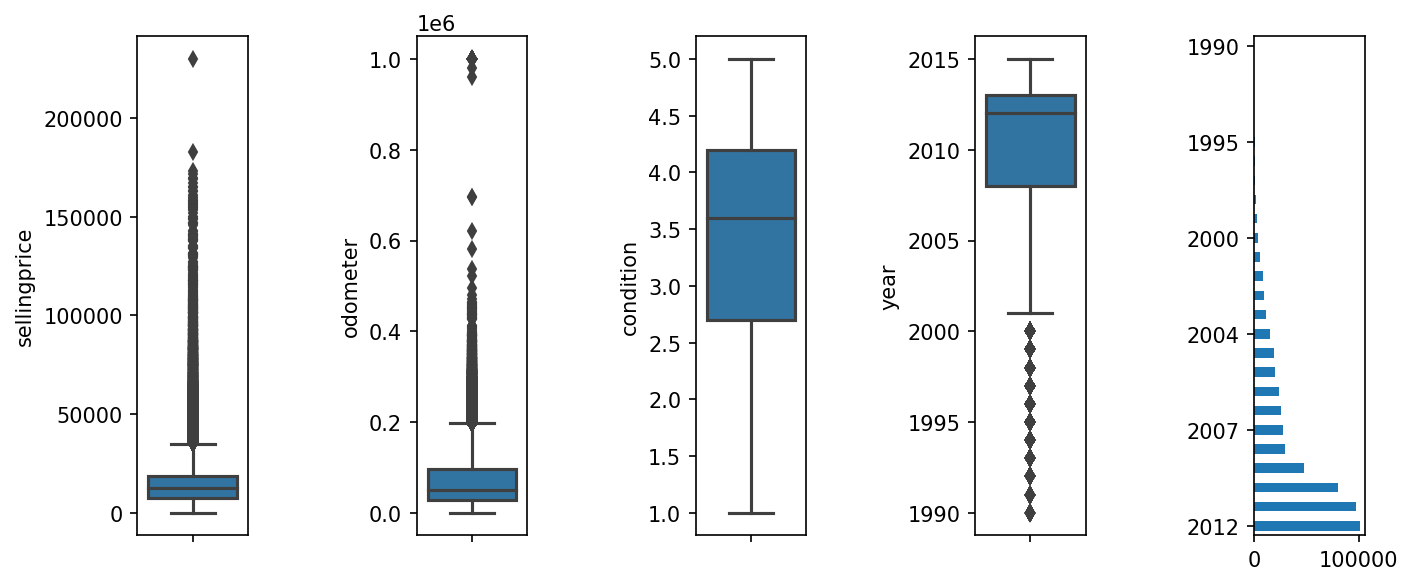

In [8]:
size = 150
plt.rcParams['figure.dpi'] = size
plt.rcParams['savefig.dpi'] = size

#check fo outliers
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
plt.tight_layout(pad=5)

ax = ax.ravel()
for index, data in enumerate(['sellingprice', 'odometer', 'condition', 'year']):
    sns.boxplot(data =car_var, y=data, ax=ax[index])
    
_  = car_var.year.value_counts().plot(kind='barh')
ax[4].locator_params(axis='y', nbins=6)

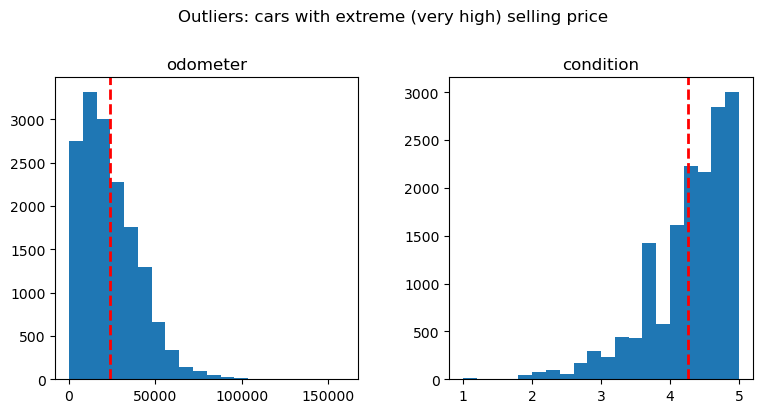

In [9]:
size = 100
plt.rcParams['figure.dpi'] = size
plt.rcParams['savefig.dpi'] = size
#check for the conditions and odometer of cars with very high selling-price
quartiles = np.quantile(car_var.sellingprice, [0.25, 0.75])
IQR = quartiles[1] - quartiles[0]
upper_bound = quartiles[1] + (1.5 * IQR)

#plot a histogram of the condition and odometer variable for this outliers
high_selling_price_cars = car_var[car_var.sellingprice >= upper_bound]
axis = high_selling_price_cars[['odometer', 'condition']].hist(figsize=(9, 4), bins=20, grid=False)

axis[0,0].axvline(high_selling_price_cars.odometer.mean(), color='red', lw = 2, ls='dashed')
axis[0,1].axvline(high_selling_price_cars.condition.mean(), color='red', lw = 2, ls='dashed')
axis[0,0].locator_params(axis='x', nbins=6)

_ = plt.suptitle('Outliers: cars with extreme (very high) selling price', y = 1.05)



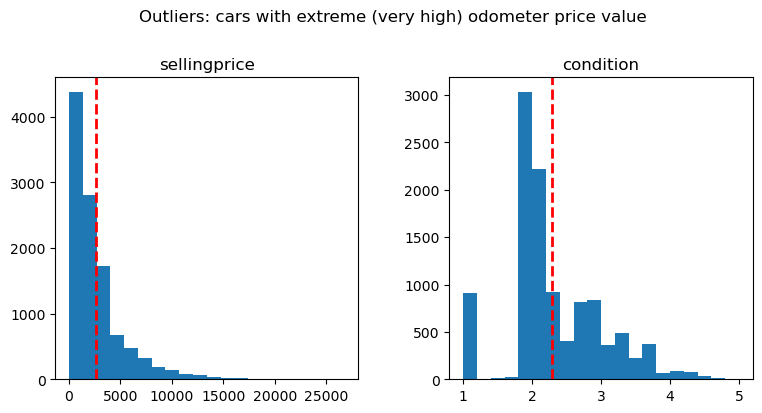

In [10]:
#check for the conditions and sellingprice of cars with very high odometer
quartiles = np.quantile(car_var.odometer, [0.25, 0.75])
IQR = quartiles[1] - quartiles[0]
upper_bound = quartiles[1] + (1.5 * IQR)

high_odometer_cars = car_var[car_var.odometer >= upper_bound]
axis = high_odometer_cars[['sellingprice', 'condition']].hist(figsize=(9, 4), bins=20, grid=False)

_ = axis[0,0].axvline(high_odometer_cars.sellingprice.mean(), color='red', lw = 2, ls='dashed')
_ = axis[0,1].axvline(high_odometer_cars.condition.mean(), color='red', lw = 2, ls='dashed')


_ = plt.suptitle('Outliers: cars with extreme (very high) odometer price value', y=1.05)

 <ul style = "background-color: #f0f5f5; 
            border-radius: 5px; padding: 15px 30px;
            font-size: 15px; line-height: 2em">
<li>Initially there seem to be outliers in the car prices. but a deeper look into the datasets reveals that these high-priced cars a perculiar to specific cars models which  includes  <code>
    bmw', 'chevrolet', 'mercedes-benz', 'lexus', 'land rover',
   'porsche', 'audi', 'ferrari', 'jaguar', 'nissan', 'bentley',
   'ford', 'rolls-royce', 'infiniti', 'maserati', 'cadillac', 'tesla',
   'toyota', 'jeep', 'gmc', 'aston martin', 'fisker', 'hyundai',
   'lamborghini', 'lincoln', 'ram', 'dodge'</code>
<br>Also checking the conditions of these high-priced cars shows left-skewed distribution with an average condition of <code>4.26</code> These extreme value are legitimate observations that is a natural part of the population being studeid, so I would  leave it in the dataset.</li>
<li>This equally holds  for cars with very high odometer values: Plotting the histogram for the conditions shows  left skewed distribution with an average condition of <code>2.3</code> and average odometer of <code>2.5k</code> </li>
<li>The year variable consist of extreme values too. These are cars sold before 2000. A barh plot shows that very few cars where sold before 2000 when compared with subsequent years. These data points in these categories would be dropped, as the model might learn the noise if included</li>
</ul>

In [11]:
#drop cars sold bofore 2000
car_var = car_var[car_var.year > 1999]

In [12]:
#check fo cars with abnormal selling
car_var[car_var.sellingprice < 100]

,year,make,model,trim,body,transmission,condition,odometer,sellingprice
35618,2003,mercedes-benz,E-Class,E500,sedan,automatic,2.1,1.0,1
274185,2014,ford,E-Series Van,E-250,e-series van,automatic,4.1,31886.0,1


 <ul style = "background-color: #f0f5f5; 
            border-radius: 5px; padding: 15px 30px;
            font-size: 15px; line-height: 2em">
<li>    The above dataframe shows three data points with a value of 1 as selling price which is very rare and unlikey. Probably, this might have been a result of error and will definitely not be good for the model
    <li>This rows would be removed</li>
</li>
</ul>

In [13]:
#drop rows with 1 as selling price
car_var = car_var[car_var.sellingprice > 100]
car_var.shape

(526234, 9)

In [14]:
# #select cars with very low odometer and low condition
car_var[ (car_var.odometer < 10)]

,year,make,model,trim,body,transmission,condition,odometer,sellingprice
665,2013,nissan,Maxima,3.5 S,sedan,automatic,1.0,1.0,1000
2776,2009,honda,Civic,LX,sedan,automatic,3.0,1.0,1000
2892,2008,honda,Civic,LX,sedan,automatic,1.0,1.0,1300
2903,2008,chrysler,300,LX,sedan,automatic,1.9,1.0,1300
2966,2008,jeep,Compass,Sport,suv,automatic,2.0,1.0,1800
...,...,...,...,...,...,...,...,...,...
528914,2012,ford,Taurus,SE,sedan,automatic,3.3,1.0,3700
529010,2015,jeep,Grand Cherokee,Limited,suv,automatic,4.0,6.0,35000
531641,2015,honda,Fit,LX,hatchback,manual,4.7,6.0,13000
532164,2001,dodge,Ram Pickup 1500,ST,regular cab,automatic,1.0,1.0,300


 <ul style = "background-color: #f0f5f5; 
            border-radius: 5px; padding: 15px 30px;
            font-size: 15px; line-height: 2em">
<li>   It is very unlikely for a car to have an odometer value of 1.0, unless in rare situations where the car had an accident after a little period of time. Perhaps, the following data points in the above dataframe suggests that this values might be as a result of error, therefore they'll be dropped as this will affect the model
</li>
</ul>

In [15]:
car_var = car_var[ (car_var.odometer > 10)]

In [16]:
car_var.shape

(525125, 9)

### Build a mulit-linear regression

<p  style = "background-color: #f0f5f5; 
            border-radius: 5px; padding: 15px 30px;
            font-size: 15px; line-height: 2em">
I have assumed that the relationship between the predictors and the target variable is linear. Hence a linear model would be built
</p>

<p style = "background-color: #f0f5f5; 
            border-radius: 5px; padding: 15px 30px;
            font-size: 15px; line-height: 2em">
    The <code>selling-price</code> and the <code>odometer</code>variables have a very high variance and higher dimension space which would bias a linear model. To solve this problem, I would reduce the dimension of the variables by Standardizing using StandardScaler
</p>

<p style = "background-color: #f0f5f5; 
            border-radius: 5px; padding: 15px 30px;
            font-size: 15px; line-height: 2em">
    Most of the feature variables are categorical. I would Use OneHotEncoding to convert them into numbers
</p>

In [17]:
#select dataset
car_var_1 = car_var.copy(deep=True)
car_var_1.head()

,year,make,model,trim,body,transmission,condition,odometer,sellingprice
0,2015,kia,Sorento,LX,suv,automatic,5.0,16639.0,21500
1,2015,kia,Sorento,LX,suv,automatic,5.0,9393.0,21500
2,2014,bmw,3 Series,328i SULEV,sedan,automatic,4.5,1331.0,30000
3,2015,volvo,S60,T5,sedan,automatic,4.1,14282.0,27750
4,2014,bmw,6 Series Gran Coupe,650i,sedan,automatic,4.3,2641.0,67000


In [64]:
#select feature and target variables
features = car_var_1[['year', 'trim', 'make', 'body', 'odometer', 'condition', 'model', 'transmission']]
target = car_var_1.sellingprice

#convert categorical variables into numbers using OneHotEncoding
categorical_features = [ 'trim', 'make', 'model', 'body', 'trim']
numerical_features = ['year', 'condition', 'odometer']

from sklearn.preprocessing import OneHotEncoder, StandardScaler

#create a oneHotEncoder object with maximum_category = 500
encoder = OneHotEncoder(min_frequency=800, handle_unknown='ignore', 
                        max_categories=45, drop='if_binary')

#encode the categorical variables
encoded_cat_df = pd.DataFrame(encoder.fit_transform(features[categorical_features]).toarray(), columns=encoder.get_feature_names_out())

#scale the numerical features: odometer, condition, year
scaler = StandardScaler()
scaled_num_df = pd.DataFrame(scaler.fit_transform(features[numerical_features]), columns=numerical_features)

#join the encoded categorical features with the numerical features datframe
features_ = encoded_cat_df.join(scaled_num_df)

In [67]:
features_.shape

(525125, 194)

In [70]:
#split data into training and test sets
import sklearn.model_selection as model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(features_, target, test_size=0.3, 
                                                                    shuffle=True, random_state=3)

#create an instance of LinearRegression
import sklearn.linear_model as linear_model
reg = linear_model.LinearRegression()

#fit the training data
reg.fit(X_train, y_train)

#predict on the test data
y_pred = reg.predict(X_test)

#fit the training data
reg.fit(X_train, y_train)

#predict on the test data
y_pred = reg.predict(X_test)

In [62]:
#create a function that takes a model and inputs and computes the metrics
import sklearn.metrics as metrics
def compute_model_metrics(model, X_test, y_test, y_pred):
    """This function takes in three arguments: a model the y_test data and the predicted y values
       and then computes the RSquared and RMSE score
       
       Args:
           model: the linear model
           y_pred: an array of predicted values using the X_test
           
        Return: Score and RMSE
    """
    
    score = round(model.score(X_test, y_test), 4)
    rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 4)
    return {'Score': score, 'RMSE': rmse}
    

In [69]:
compute_model_metrics(reg, X_test, y_test, y_pred)

{'Score': 0.7264, 'RMSE': 5047.7577}

<ul>
   <h3 >RSquared: <span style = "color: green;">.7349</span></h3>
   <h3>RMSE: 4930.39</h3>
<ul>


## Synopsis


<ul  style = "background-color: #f0f5f5; 
            border-radius: 5px; padding: 15px 30px;
            font-size: 15px; line-height: 2em">
    The model achieved an appreciable accuracy score and RMSE value. But There's need for improvement. 
    <h2>What can be done ?</h2>
    <li>Non Linear Model: The initial assumption made about the relationship between the predictors and target may probably not be the case. There's a possibilty of havinga non-linear relationship between the target and     the predictors. Fitting a non-linear model using polynomialFeatures from scikit-learn preprocessing module will create additional features (+ the ones added by oneHot Encoding) which will further increase the    dimension of the dataset. Working with such dimension would be too computationally expensive</li>
    <li>Another Model</li>      
    <h2>What Worked ?</h2>
     <li>Encoding: Encoding the categorical variables with oneHotEncoding did improve the model very well. The other encoding method utilized was ordinal encoding which performed worse than OneHot. This could be traced to the nature of the datasets and labels. All categorical variables in the dataset represents types and models of cars which are not in a particular order or rank</li>   
    <li>Standardizing: Using standardScaler from sklearn, the numerical features such as year, odometer, condition were scaled down to avoid bias due to high dimensions</li>
    <li>Removing Outliers: Dropping cars sold before the year 1999 improved the model accuracy. It turned out the models was learning the noise as very few cars were sold b4 then</li>
</ul>